# Сеть фитнес-центров «Культурист-датасаентист». Анализ оттока клиентов.

Существующая проблема: отток клиентов в фитнес-центре «Культурист-датасаентист».
Для нашего анализа клиент попал в отток, если за последний месяц ни разу не посетил спортзал.
«Культурист-датасаентист» предоставил нам данные в виде клиентских анкет. Они содержат информацию на месяц до оттока и факт оттока на определённый месяц.

Задачи анализа:
- спрогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента
- сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства
- проанализировать основные признаки, наиболее сильно влияющие на отток
  

 ## Исследовательский анализ данных (EDA)
     - Общий взгляд на данные 
     - Средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался
     - Столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток)
     - Матрица корреляций 

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn import datasets
import seaborn as sns
import itertools


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore') 


In [2]:
data = pd.read_csv('/datasets/gym_churn.csv')
data.columns = data.columns.str.lower()
data.head(5)

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [3]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
near_location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


In [4]:
data.duplicated().sum()

0

Выводы по первому анализу данных:

- По половому признаку нет сильного перевеса 
- Большинство клиентов живет или работает поблизости
- Половина клиентов является сотрудниками компаний-партнёров клуба 
- Средний возраст посетителей 29 лет
- Среднее по оттоку 0.26

Дубликатов нет, пропусков нет.


Перейдем к следующему. Посмотрим средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался, и построим столбчатые гистограммы.

In [5]:
 data.groupby('churn').agg('mean').T

churn,0,1
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
month_to_end_contract,5.283089,1.662582


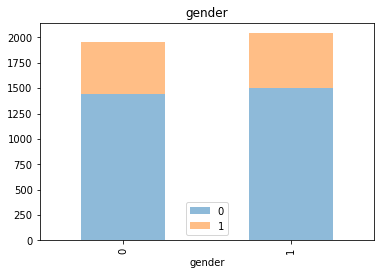

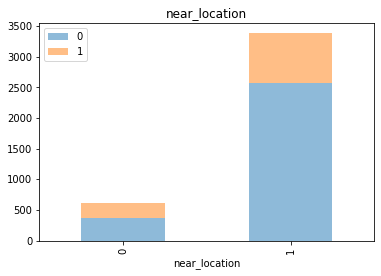

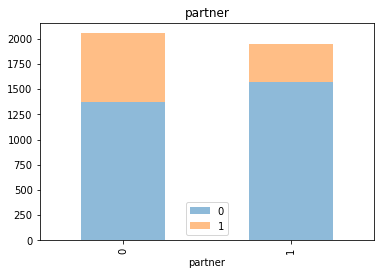

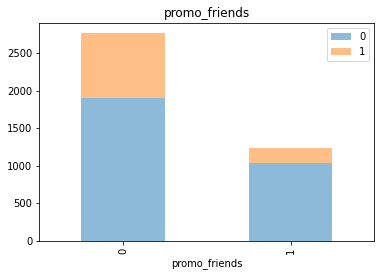

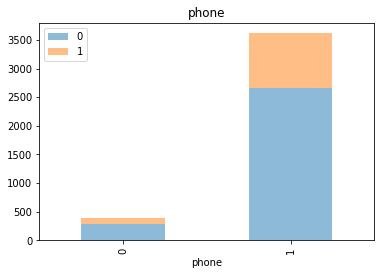

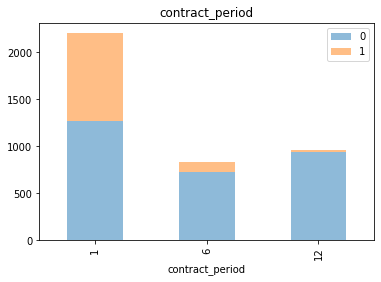

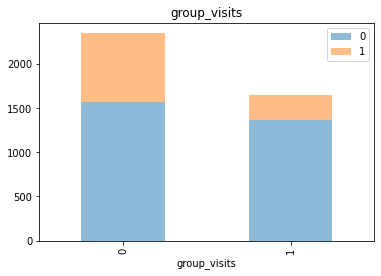

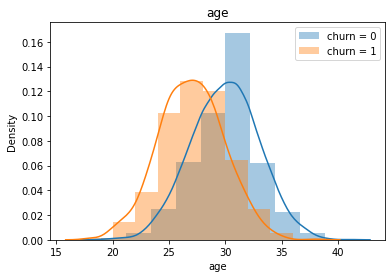

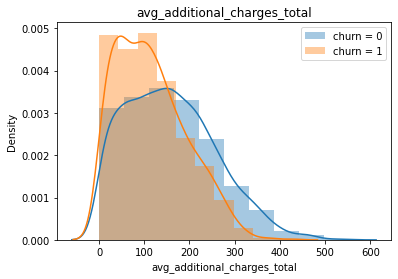

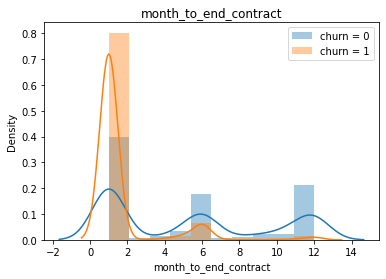

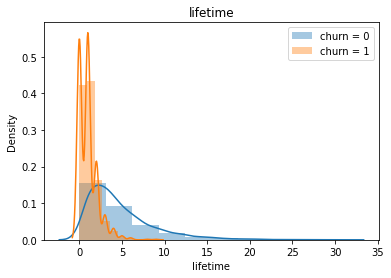

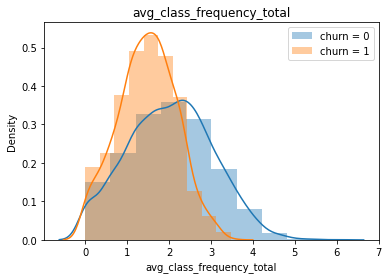

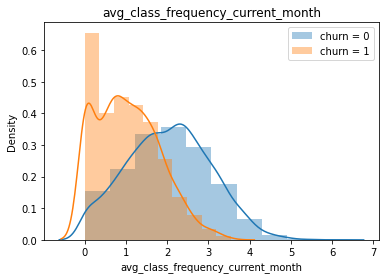

In [6]:
def feat_hist(x, group_col, key_cols):
    x_new = x.copy()[key_cols]
    for c in key_cols:
 
        if c == group_col: continue
 
        if len(x_new[c].unique()) < 10:
            report = x_new.reset_index().pivot_table(index=c, columns=group_col, values='index', aggfunc='count')
            report.plot(kind='bar', stacked=True, alpha=0.5)
 
        else:
            for c1 in x[group_col].unique():
                sns.distplot(x_new[x_new[group_col] == c1][c],
                             label = '{} = {}'.format(group_col, str(c1)), bins=10)
 
        plt.title(c)
        plt.legend()
        plt.show()
 
feat_hist(data, 'churn', data.columns)

    

Выводы: 

    - Большинство живет рядом, этот показатель влияет на отток. Среди них многие остались.
    - Наблюдается разница в числа людей, пришедших по промокодам. С промокодами большинство осталось.
    - Длительность абонемента влияет на отток, с годовыми абонементами уходят реже.
    - Посещающие групповые занятия уходят реже.
    - По графику с оставшимися месяцами хорошо видны всплески типичных абонементов по 6 и 12 месецев. Отток обыно среди тех, у кого оасталось не более 2 месяцев.
    - Большой отток у новичков.
     - По частоте посещений: чем меньше раз посещает, тем больше отток. 



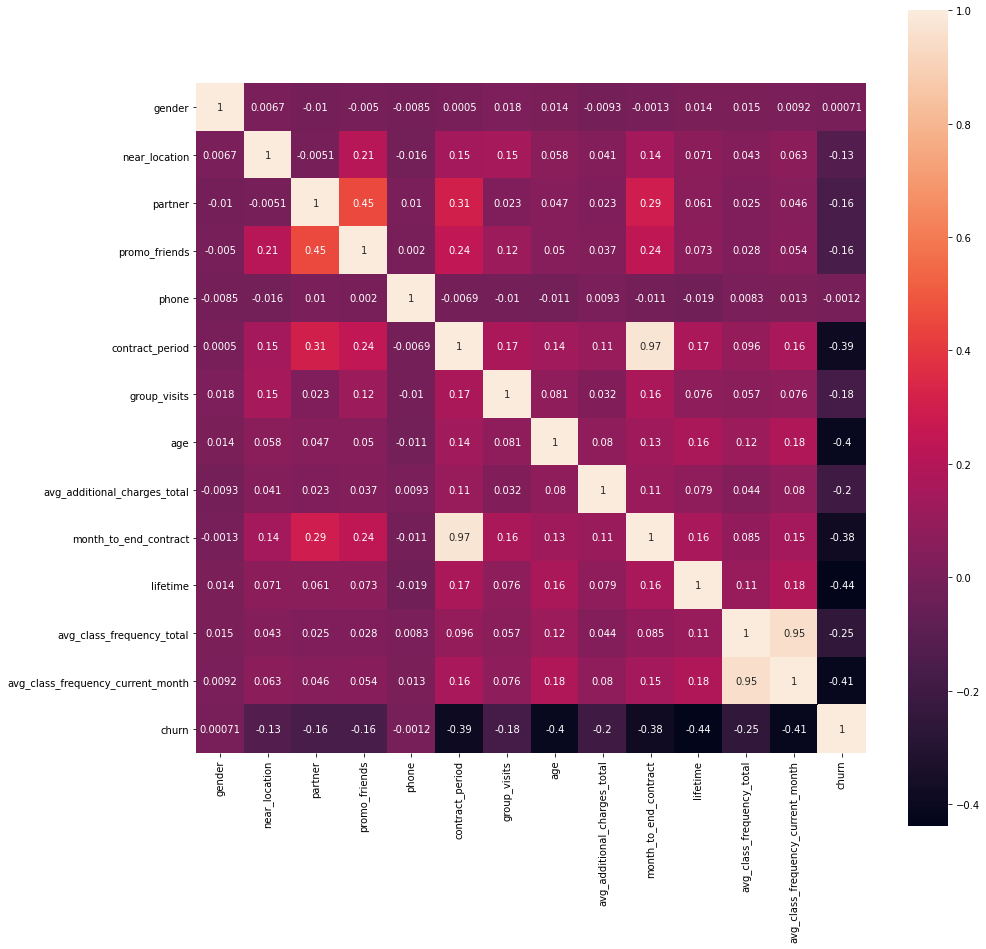

In [7]:
corr_m = data.corr() 
plt.figure(figsize=(15,15))
sns.heatmap(corr_m, square = True, annot = True)
plt.show()

Судя по матрице у нас есть мультиколлинеарные параметры. Удалим по одному из параметров из каждой пары.

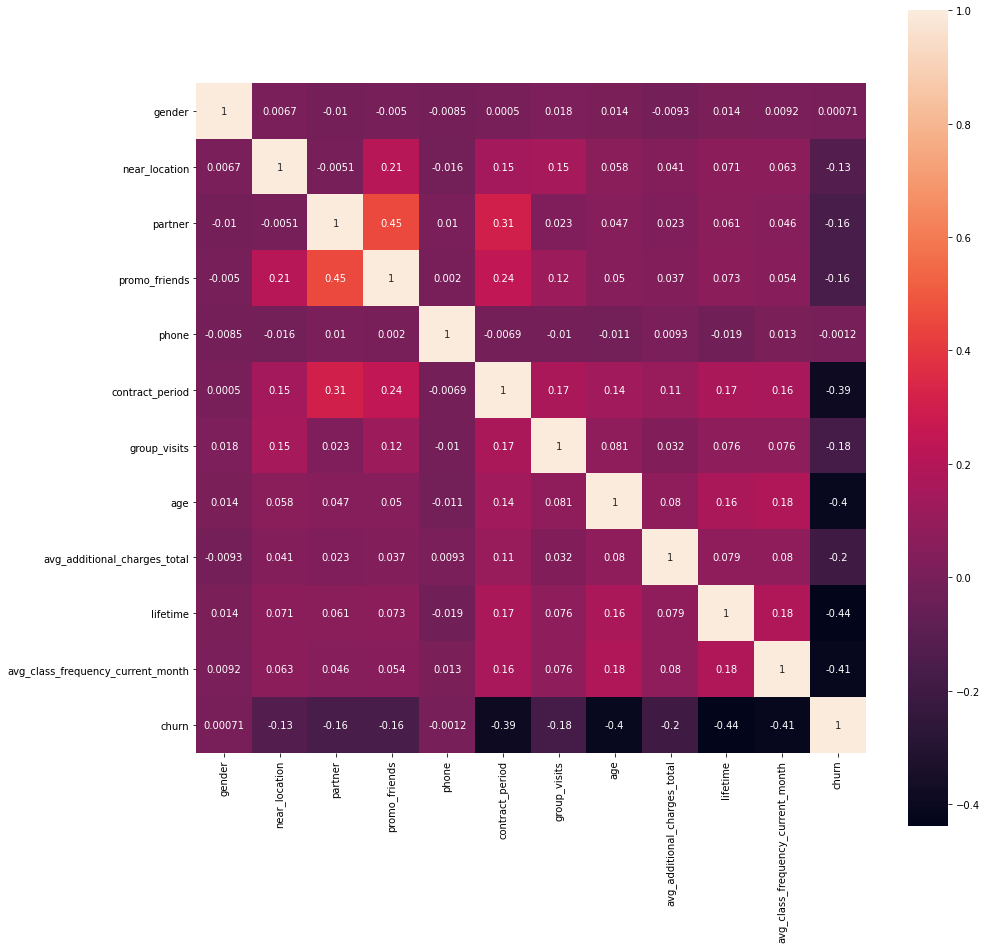

In [8]:
data = data.drop('month_to_end_contract', axis = 1)
data = data.drop('avg_class_frequency_total', axis = 1)
corr_m = data.corr() 
plt.figure(figsize=(15,15))
sns.heatmap(corr_m, square = True, annot = True)
plt.show()

Вывод по матрице корреляции: 

    - Самая высокая коррелция с оттоком наблюдается у возраста, длительности абонемента, возраста, времени с момента первого обращения в фитнес-центр, частотой посещения за предыдущий месяц.
    - Наличие телефона, как и ранее, не показало никакой зависимости. 
    - Партнерство и промокоды, а также близость дома или работы по матрице корреляции наоборот показали слабые результаты.

Общие выводы после EDA：

- По половому признаку нет сильного перевеса 
- Большинство клиентов живет или работает поблизости
- Половина клиентов является сотрудниками компаний-партнёров клуба 
- Средний возраст посетителей 29 лет
- Среднее по оттоку 0.26

Выводы по среднему значения с разбивкой по оттоку:

- Большинство живет рядом, этот показатель влияет на отток. Среди них многие остались.
- Наблюдается разница в числа людей, пришедших по промокодам. С промокодами большинство осталось.
- Длительность абонемента влияет на отток, с годовыми абонементами уходят реже.
- Посещающие групповые занятия уходят реже.
- По графику с оставшимися месяцами хорошо видны всплески типичных абонементов по 6 и 12 месецев. Отток обыно среди тех, у кого оасталось не более 2 месяцев.
- Большой отток у новичков.
- По частоте посещений: чем меньше раз посещает, тем больше отток. 
 
 Вывод по матрице корреляции: 

- Самая высокая коррелция с оттоком наблюдается у возраста, длительности абонемента, возраста, времени с момента первого обращения в фитнес-центр, частотой посещения за предыдущий месяц. 
- Наличие телефона, как и ранее, не показало никакой зависимости. 
- Партнерство и промокоды, а также близость дома или работы по матрице корреляции наоборот показали слабые результаты.
 
 Удалили мультиколлинеарные параметры.

## Модель прогнозирования оттока клиентов

Целевой признак — факт оттока клиента в следующем месяце

Сначала разобьем данные на обучающую и валидационную выборку функцией train_test_split()

In [9]:
X = data.drop('churn', axis = 1)
y = data['churn']

#разделяем модель на обучающую и валидационную выборки, соотношение укажем 0.2,  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) 

#создадим объект класса StandardScaler и применим его к обучающей выборке
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)
print(X_train_st[:5])

X_test_st = scaler.transform(X_test) 

[[-1.01511421  0.4175068   1.03175391  1.4800097   0.31628211  1.60502986
  -0.84769226  0.57944798  0.37161711  1.12734972  1.61822807]
 [-1.01511421  0.4175068  -0.96922337 -0.67567125  0.31628211 -0.81299073
  -0.84769226  0.27046055 -1.09697378  5.88138322 -0.01340886]
 [ 0.98511083  0.4175068   1.03175391 -0.67567125  0.31628211  1.60502986
  -0.84769226 -0.65650171 -1.18374157  0.3350108  -0.80541199]
 [-1.01511421  0.4175068   1.03175391  1.4800097   0.31628211  0.28610954
  -0.84769226 -0.96548914 -0.95158829  1.39146269  0.64605224]
 [-1.01511421  0.4175068  -0.96922337 -0.67567125 -3.16173427 -0.81299073
  -0.84769226 -0.03852687  0.97190435  0.07089783 -0.16038147]]


Обучим модель на train-выборке двумя способами: логистической регрессией и случайным лесом.
Выведем метрики accuracy, precision и recall и сравним модели.

In [10]:
# определим функцию, которая будет выводить наши метрики
def print_all_metrics(y_true, y_pred, y_proba, title='Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    

#модель логистической регрессии
lr_model = LogisticRegression(random_state=0)
lr_model.fit(X_train_st, y_train)
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:, 1]
print_all_metrics(
    y_test,
    lr_predictions,
    lr_probabilities,
    title='Метрики для модели логистической регрессии:',
)

#алгоритмм случайного леса
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0) 
rf_model.fit(X_train_st, y_train)
rf_predictions = rf_model.predict(X_test_st)
rf_probabilities = rf_model.predict_proba(X_test_st)[:, 1] 
print_all_metrics(
    y_test,
    rf_predictions,
    rf_probabilities, 
    title='Метрики для модели случайного леса:'
)


Метрики для модели логистической регрессии:
	Accuracy: 0.90
	Precision: 0.79
	Recall: 0.82
Метрики для модели случайного леса:
	Accuracy: 0.90
	Precision: 0.81
	Recall: 0.75


Выводы: 

Модель логистической регрессии показала себя буквально чуть-чуть лучше по метрикам Precision и Recall. Точность у модели логистической регрессии и случайного леса одинаковая.

## Кластеризация клиентов


Стандартизируем данные, далее применем функцию linkage() и нарисуем дендрограмму.

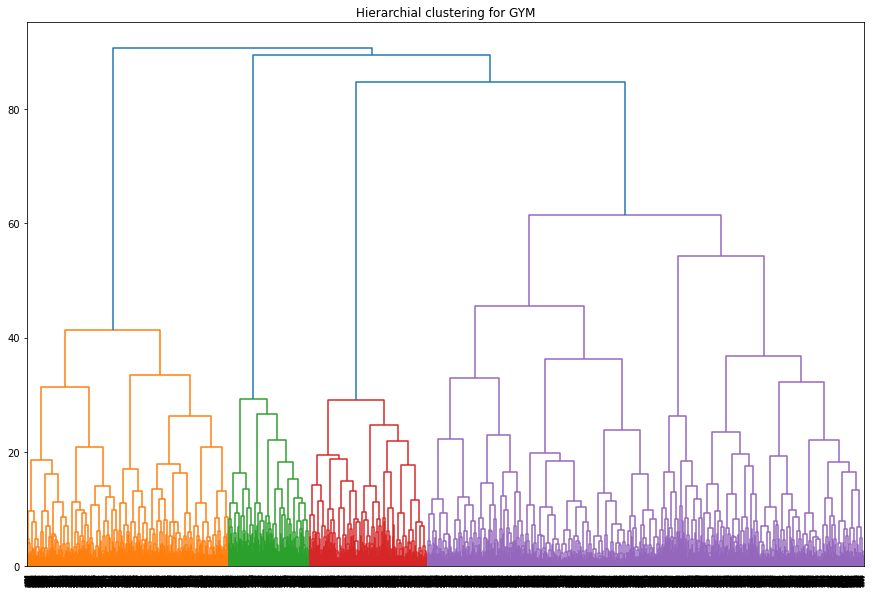

In [11]:
X = data.drop('churn', axis = 1)
y = data['churn']
sc = StandardScaler()
X_sc = sc.fit_transform(X)

linked = linkage(X_sc, method = 'ward')
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Hierarchial clustering for GYM')
plt.show()

Цветов получилось 4, визуально 5-6 кластеров есть. По заданию у нас идет 5 кластеров для дальнейшего анализа.

Обучим модель кластеризации на основании алгоритма K-Means. Число кластеров - n=5.
  

In [12]:
sc = StandardScaler()
x_sc = sc.fit_transform(data)
 
# задаём модель k_means и значение random_state
km = KMeans(n_clusters=5, random_state=0)
labels = km.fit_predict(x_sc)
data['cluster_km'] = labels # сохраним на датасет кластеры





Посмотрим на средние значения признаков для кластеров

In [13]:
clusters = data.groupby(['cluster_km']).mean().T
display(clusters)

cluster_km,0,1,2,3,4
gender,0.500898,0.515504,0.523316,0.501446,0.513699
near_location,0.000000,0.999225,0.862694,0.992285,1.000000
partner,0.486535,0.215504,0.471503,0.936355,0.335616
promo_friends,0.073609,0.055039,0.305699,0.810029,0.224658
phone,1.000000,1.000000,0.000000,1.000000,1.000000
contract_period,2.989228,3.871318,4.777202,8.632594,1.739726
group_visits,0.236984,0.459690,0.427461,0.527483,0.290411
age,28.700180,30.053488,29.297927,29.926712,26.902740
avg_additional_charges_total,137.060646,160.909493,144.208179,158.815978,114.386793
lifetime,2.987433,4.747287,3.940415,4.702025,0.978082


Возраст в кластерах примерно один и тот же. Кластеры различаются по месту жительства или работы клиентов. Партернская программа или промокод. По длительности контракта, посещают ли групповые занятия. Сколько прошло времмени с первого посещения, тут кластер 4 отличается от других больше всего. 
Что касается оттока, самый большой отток в кластере 4 и 0. 


Построим распределения признаков для кластеров при помощи гистограмм, воспользуемся функцией выше, изменив некоторые параметры. 
  

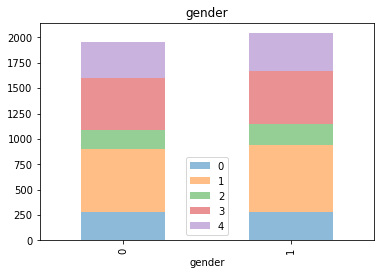

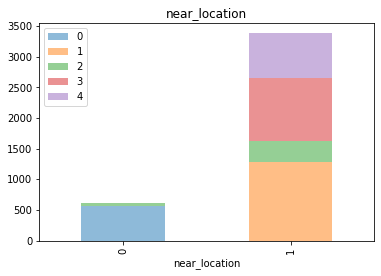

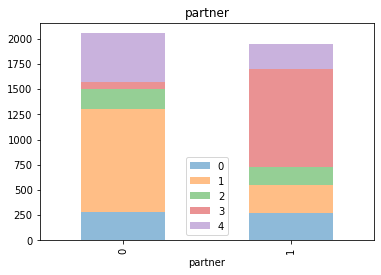

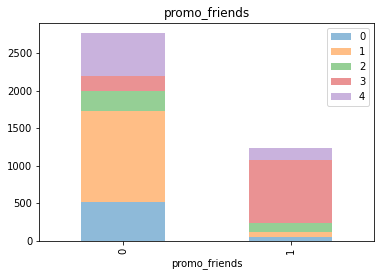

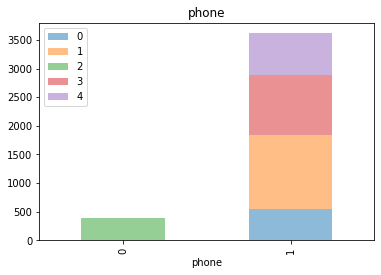

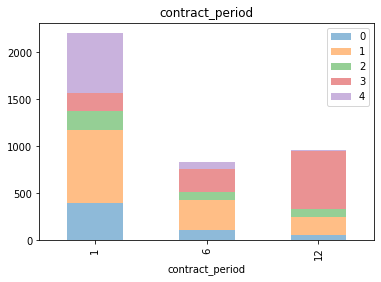

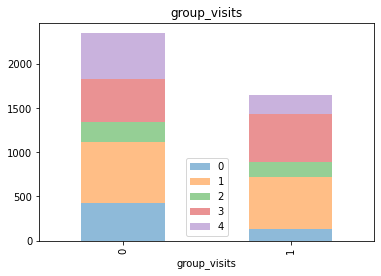

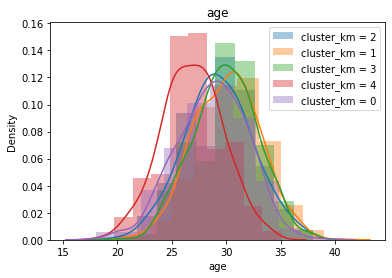

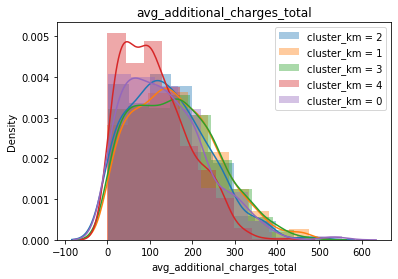

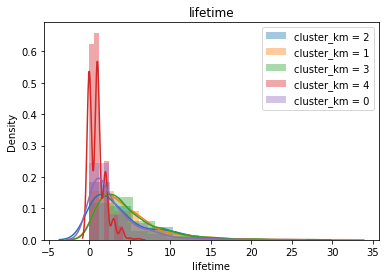

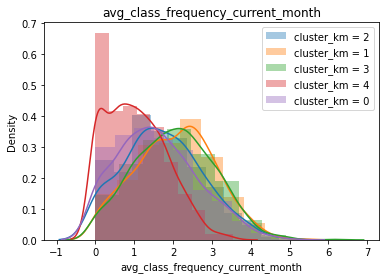

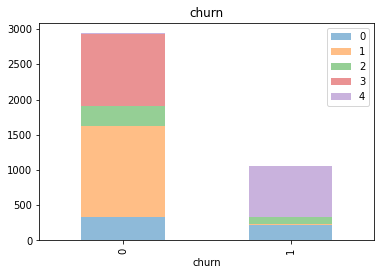

In [14]:
def cl_hist(x, group_col, key_cols):
    x_new = x.copy()[key_cols]
    for c in key_cols:
 
        if c == group_col: continue
 
        if len(x_new[c].unique()) < 10:
            report = x_new.reset_index().pivot_table(index=c, columns=group_col, values='index', aggfunc='count')
            report.plot(kind='bar', stacked=True, alpha=0.5)
 
        else:
            for c1 in x[group_col].unique():
                sns.distplot(x_new[x_new[group_col] == c1][c],
                             label = '{} = {}'.format(group_col, str(c1)), bins=10)
 
        plt.title(c)
        plt.legend()
        plt.show()
 
cl_hist(data, 'cluster_km', data.columns)



    - Кластер 0 составляет большую часть среди тех, кто живет неблизко. Из живущих поблизости видим кластеры 1, 3 и 4.
    - Партенрская программа - не являются клиентами в кластере 1, являются в кластере 3.
    - Промокодами пользовались клиенты из кластера 3, не пользовались 1 кластер.
    - Телефон не оставляли 2 кластер. Оставившие телефон распределны более менее ровно.
    - Длительность абоненемента 1 месяц - 2 и 4 кластеры. 6 месяцов - 1 и 3. 12 месяцев - 3.
    - Больше всего видимо, что меньше всего прошло времени с первого посещения в кластере 4. 
    - Также 4 кластер отличается меньшей частотой посещений за предыдущий месяц.
    - Больше всего оттока в кластере 4, самые стабльные 1 и 3.
    - Кластер 4 немного выделяется по выручке с других услуг.


 Для каждого полученного кластера посчитем долю оттока (методом groupby()).

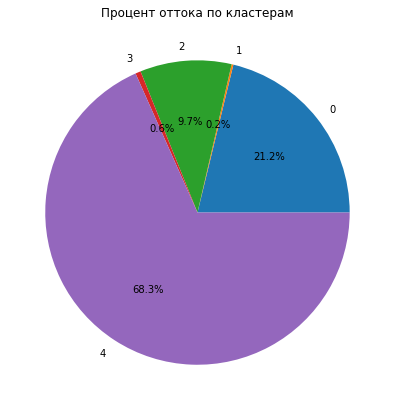

In [15]:
x= data.query('churn==1').groupby('cluster_km')['churn'].sum() / data.query('churn==1')['churn'].sum() 
people = x.index
plt.figure(figsize=(15,7))
plt.pie(x=x, labels=people, autopct='%1.1f%%')
plt.title('Процент оттока по кластерам')
plt.show()


Выводы по кластеризации клиентов: 

Кластеры с наименьшим оттоком - 1 и 3. 
    В эти кластеры входят люди около 30 лет, судя по кластерам, они могут как и юыть участниками партнерской программы, так и нет. Тоже самое с промокодами. Клиенты 1 кластера ими не пользовались, но показывают стабильный результат, как и клиенты из 3 кластера, воспользовавшиеся промокодами. Абонементы длительные - 6 или 12 месяцев. Живут или работают поблизости. Стабильно посещают центр несколько раз в месяц. 
     
Кластер с наибольшим оттоком - 4.
    Живут поблизости, однако нет промокода и не являются участниками программы партнерства. Пришли в фитнес-центр не более 2 месяцев назад, мало посещают групповые занятия, средний возраст 26-27 лет. Абоненемент на месяц. Судя по всему, сходили один раз, также прибрели дополнительные услуги в центре, о чем свидетельствует график выручки.

## Выводы и базовые рекомендации по работе с клиентами

Общие выводы после EDA：

- По половому признаку нет сильного перевеса 
- Большинство клиентов живет или работает поблизости
- Половина клиентов является сотрудниками компаний-партнёров клуба 
- Средний возраст посетителей 29 лет
- Среднее по оттоку 0.26 
- Наблюдается разница в числа людей, пришедших по промокодам. С промокодами большинство осталось.
- Длительность абонемента влияет на отток, с годовыми абонементами уходят реже.
- Посещающие групповые занятия уходят реже.
- По графику с оставшимися месяцами хорошо видны всплески типичных абонементов по 6 и 12 месецев. Отток обыно среди тех, у кого оасталось не более 2 месяцев.
- Большой отток у новичков.
- Самая высокая коррелция с оттоком наблюдается у возраста, длительности абонемента, возраста, времени с момента первого обращения в фитнес-центр, частотой посещения за предыдущий месяц. 
- Наличие телефона, как и ранее, не показало никакой зависимости. 
- Партнерство и промокоды, а также близость дома или работы по матрице корреляции наоборот показали слабые результаты.

Выводы после построения моделей: 

Модель логистической регрессии показала себя буквально чуть-чуть лучше по метрикам Precision и Recall. Точность у модели логистической регрессии и случайного леса одинаковая.

Выводы по кластеризации клиентов: 
Выделили 5 кластеров. 

Кластеры с наименьшим оттоком - 1 и 3. 
    В эти кластеры входят люди около 30 лет, судя по кластерам, они могут как и юыть участниками партнерской программы, так и нет. Тоже самое с промокодами. Клиенты 1 кластера ими не пользовались, но показывают стабильный результат, как и клиенты из 3 кластера, воспользовавшиеся промокодами. Абонементы длительные - 6 или 12 месяцев. Живут или работают поблизости. Стабильно посещают центр несколько раз в месяц. 
     
Кластер с наибольшим оттоком - 4.
    Живут поблизости, однако нет промокода и не являются участниками программы партнерства. Пришли в фитнес-центр не более 2 месяцев назад, мало посещают групповые занятия, средний возраст 26-27 лет. Абонемент на месяц. Судя по всему, сходили один раз, также приобрели дополнительные услуги в центре, о чем свидетельствует график выручки.

Рекомендации: 

- Исходя из среднего возраста клиента (30 лет), можно рассмотреть вариант расширения партнерских программ и дополнительных промокодов для компаний. 
- Проработать стратегию продаж абонементов более 6 месяцев. 
- Посмотреть ситуацию с групповыми занятиями, стабильные клиенты их посещают, возможно, новичкам трудно разобраться с расписанием или слаба построена система знакомства с клубом.
